# 日経平均株価 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'N225'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='1y', interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-04-01 00:00:00+09:00,40646.699219,40697.218750,39706.449219,39803.089844,134500000,0.0,0.0
2024-04-02 00:00:00+09:00,39892.589844,40151.050781,39707.871094,39838.910156,115800000,0.0,0.0
2024-04-03 00:00:00+09:00,39503.718750,39625.898438,39217.039062,39451.851562,123200000,0.0,0.0
2024-04-04 00:00:00+09:00,39928.328125,40243.019531,39773.140625,39773.140625,145100000,0.0,0.0
2024-04-05 00:00:00+09:00,39237.390625,39274.761719,38774.238281,38992.078125,129600000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-25 00:00:00+09:00,37953.148438,38115.648438,37686.261719,37780.539062,107300000,0.0,0.0
2025-03-26 00:00:00+09:00,38106.660156,38220.691406,37873.281250,38027.289062,117100000,0.0,0.0
2025-03-27 00:00:00+09:00,37750.660156,37859.058594,37556.750000,37799.968750,140000000,0.0,0.0


In [3]:
df0 = ticker.history(period='2y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-03-31 00:00:00+09:00,28009.220703,28124.619141,27986.619141,28041.480469,91100000,0.0,0.0
2023-04-03 00:00:00+09:00,28203.349609,28258.910156,28120.710938,28188.150391,75000000,0.0,0.0
2023-04-04 00:00:00+09:00,28213.929688,28287.419922,28139.119141,28287.419922,73300000,0.0,0.0
2023-04-05 00:00:00+09:00,28111.039062,28133.570312,27788.769531,27813.259766,74300000,0.0,0.0
2023-04-06 00:00:00+09:00,27589.140625,27609.859375,27427.660156,27472.630859,73200000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-25 00:00:00+09:00,37953.148438,38115.648438,37686.261719,37780.539062,107300000,0.0,0.0
2025-03-26 00:00:00+09:00,38106.660156,38220.691406,37873.281250,38027.289062,117100000,0.0,0.0
2025-03-27 00:00:00+09:00,37750.660156,37859.058594,37556.750000,37799.968750,140000000,0.0,0.0


## Moving Median

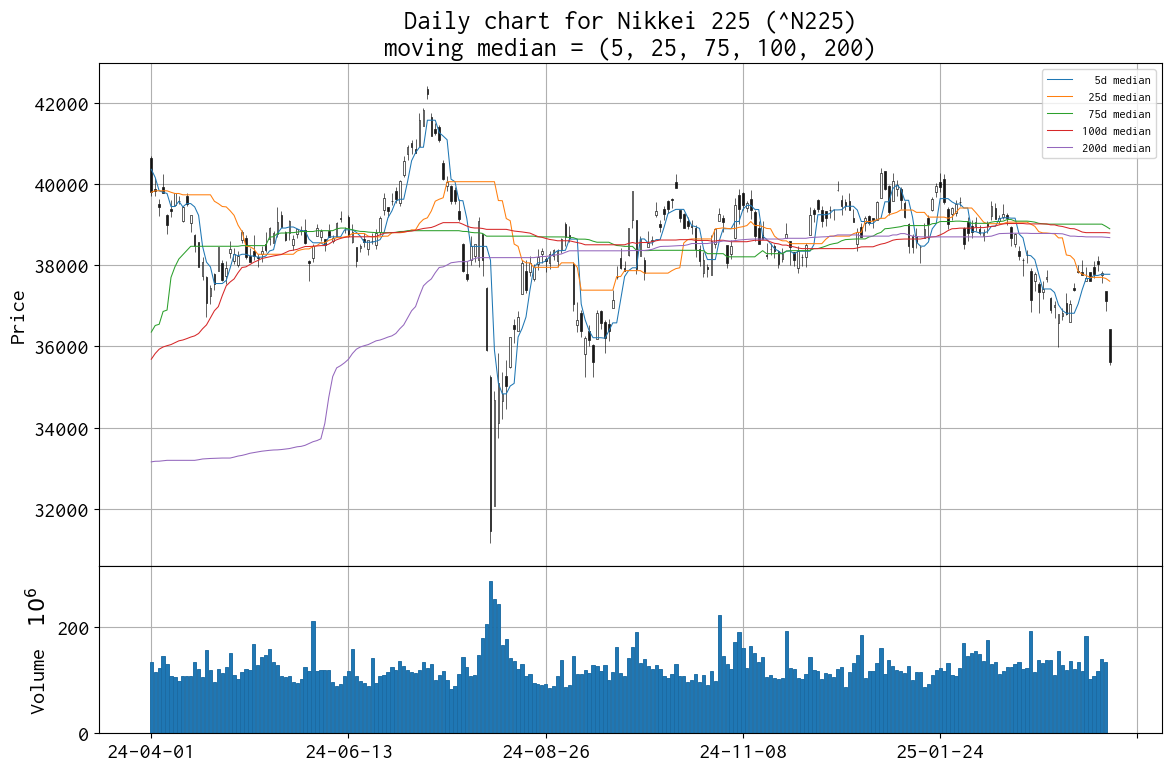

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax[0]),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax[0]),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax[0]),
]   

mpf.plot(
    df, type='candle', style='default',
    volume=ax[1],
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)

ax[0].set_title('Daily chart for %s (%s)\nmoving median = (5, 25, 75, 100, 200)' %(ticker.info['longName'], symbol))
ax[0].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-28 00:00:00+09:00,37357.519531,37359.949219,36864.929688,37120.328125,133200000,0.0,0.0
2025-03-31 00:00:00+09:00,36440.179688,36440.179688,35541.718750,35604.898438,0,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-03-28 00:00:00+09:00    37120.328125
2025-03-31 00:00:00+09:00    35604.898438
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-03-28 00:00:00+09:00            NaN
2025-03-31 00:00:00+09:00   -1515.429688
Name: Close, dtype: float64

In [8]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-31 00:00:00+09:00   -835.28125
dtype: float64

In [9]:
df['Close'].rolling(9).median().tail()

Date
2025-03-25 00:00:00+09:00    37608.488281
2025-03-26 00:00:00+09:00    37677.058594
2025-03-27 00:00:00+09:00    37751.878906
2025-03-28 00:00:00+09:00    37751.878906
2025-03-31 00:00:00+09:00    37751.878906
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail()

Date
2025-03-25 00:00:00+09:00    37396.519531
2025-03-26 00:00:00+09:00    37396.519531
2025-03-27 00:00:00+09:00    37608.488281
2025-03-28 00:00:00+09:00    37608.488281
2025-03-31 00:00:00+09:00    37608.488281
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail()

Date
2025-03-25 00:00:00+09:00    37728.404297
2025-03-26 00:00:00+09:00    37728.404297
2025-03-27 00:00:00+09:00    37728.404297
2025-03-28 00:00:00+09:00    37690.994141
2025-03-31 00:00:00+09:00    37642.773438
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail()

Date
2025-03-25 00:00:00+09:00    38727.490234
2025-03-26 00:00:00+09:00    38625.320312
2025-03-27 00:00:00+09:00    38546.345703
2025-03-28 00:00:00+09:00    38497.195312
2025-03-31 00:00:00+09:00    38462.880859
Name: Close, dtype: float64

## Robust Bollinger's bands

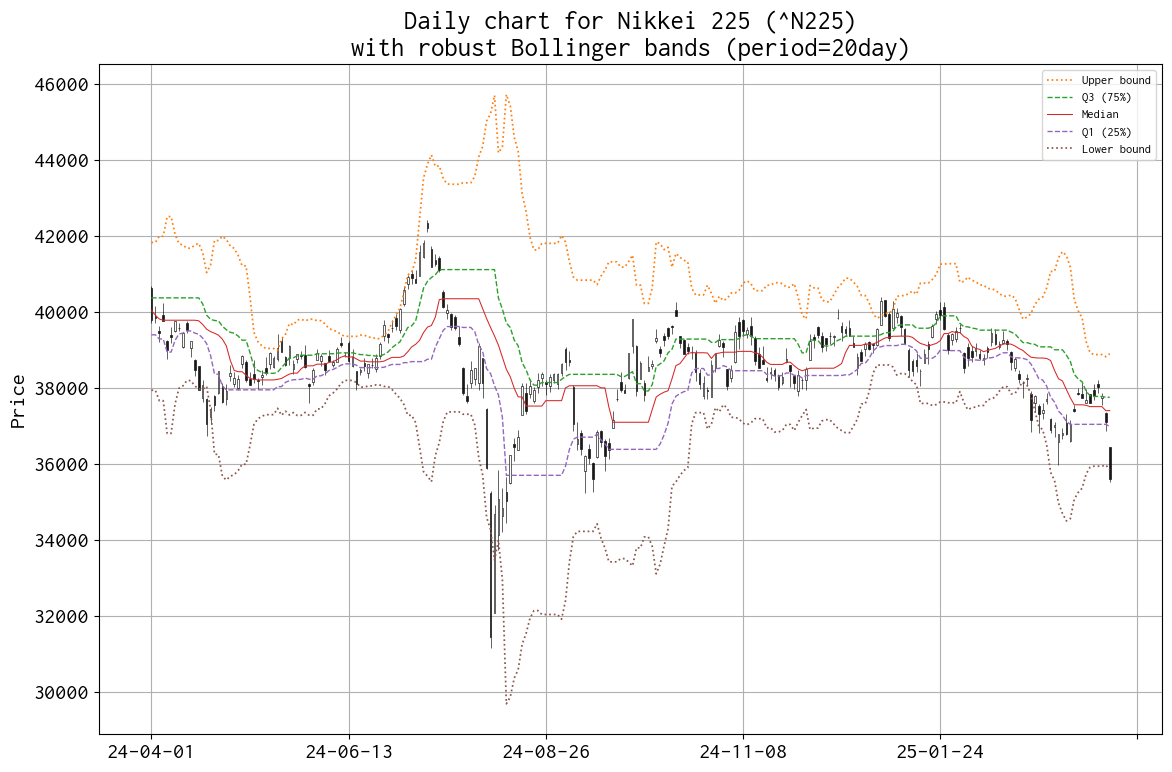

In [13]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%dday)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%dday)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラムと Q-Q プロット

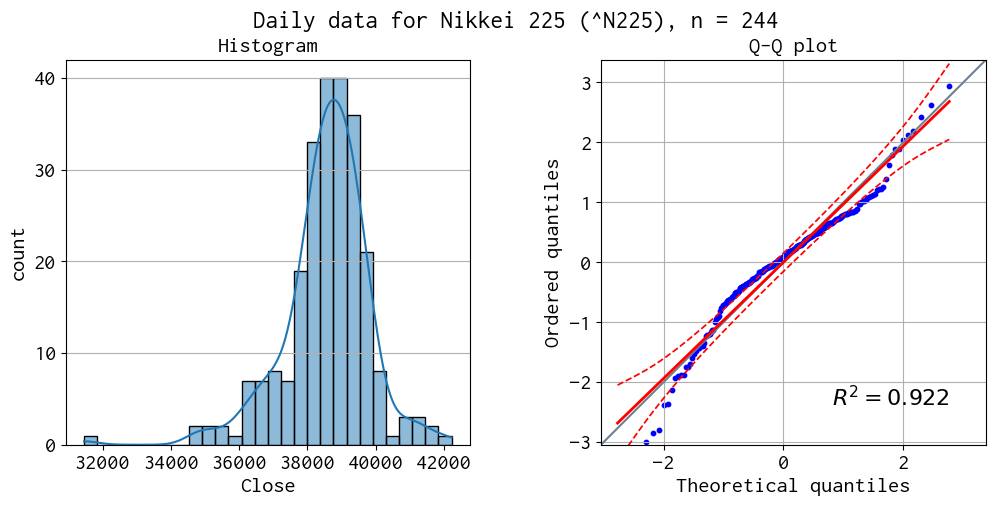

In [14]:
plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_daily_histogram_qqplot_%s.png' % code)
plt.show()